# Input Data Processing
This Jupyter notebook contains code to process automatic weather station (AWS) data to a standardized format for the PyGEM-EB model. The AWS dataset should be in a single comma/tab-separated file containing all timesteps and all data variables. If the data is not in that format, first use preprocess_AWS.ipynb. Note that this code may not be comprehensive for all errors that arise from the formatting of a specific dataset. 

In [1]:
import numpy as np
import os
import xarray as xr
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## Set-up: Define variables
Fill out the cell below to set up the glacier being accessed and the filepaths.

### Lines you should edit are marked with three asterisks (***). Use CTRL+F to highlight all instances and ease usage of this notebook.

In [2]:
# =========== Check all the variables below this line for a new glacier ===========
# STATION INFORMATION   
glac_name = 'gulkana'           # *** Glacier name for output file corresponding to PEBSI/data/glacier_metadata    
station_name = 'B2025'          # *** Descriptive name for log and output (e.g. site name, year, etc.)
elev = 1682                     # *** Elevation of AWS [m a.s.l.]
lat = 63.285514                 # *** Latitude of AWS [decimal degrees]
lon = -145.410336               # *** Longitude of AWS [decimal degrees]
station_type = 'on-ice'         # *** Type of station (on-ice, off-ice, or debris)

# TIMEZONE
timezone = 'GMT-08'             # *** Timezone of output data (should be local time)
input_timezone = 'GMT-00'       # *** Time zone of input data

# DATA FILEPATHS
data_fn = 'Raw/gulkana/gulkanaB_2025.csv'                     # *** Filename of input data (relative to data_fp)

# =========== Below this line, you do not need to make any edits ===========
# OUTPUT FILEPATHS
data_fp = '../../../climate_data/AWS/'                      # Filepath to the folder of input data
export_fp = '../../../climate_data/AWS/Processed/'          # Filepath to the folder to save this data
export_fn = export_fp + glac_name +'/'
if not os.path.exists(export_fn):
    os.mkdir(export_fn)                                     # Make folder for this glacier
export_fn += glac_name + station_name + '.csv'              # Name of output file
metadata_fn = '../../data/aws_metadata.txt'                 # Name of metadata file
if not os.path.exists(metadata_fn):   
    print('Creating metadata file for weather stations')             
    with open(metadata_fn, 'w') as f:
        f.write('glacier\tstation\televation\tlatitude\tlongitude\ttype\n')         # Write metadata text file header

# MINIMUM DATA PERCENTAGE
data_min_percentage = 0.8       # Below this threshold of data coverage, specific variables will be thrown out

## 1. Load Data
From the output of the first cell, make sure the columns have been properly loaded. 

The cell below contains a dictionary with the possible for each variable. If the column names you want to use are missing, add those to the "names" dictionary.

Also specify the name of the time column and any NaN values specific to this dataset.

In [3]:
# Read in the data and make sure the columns were correctly loaded
# Note: this step is likely to cause errors that can be fixed by adjusting the input arguments, for example delim_whitespace
rows_to_skip = 1     # Number of rows that contain text at the beginning of the file
df = pd.read_csv(data_fp + data_fn,skiprows=rows_to_skip).iloc[6:]  # May need to change sep to \t if tab-separated
print(df.columns.to_numpy())
print(df.head())

['TIMESTAMP' 'RECORD' 'Par_FarRed_1_Avg' 'FarRed_1_Avg' 'Par_FarRed_2_Avg'
 'FarRed_2_Avg' 'TargetTemp_Avg' 'AirTC_Avg' 'RH' 'WS_ms_Avg' 'WS_ms_Max'
 'WS_ms_WVc(1)' 'WS_ms_WVc(2)' 'T109_C_Avg' 'Rain_mm_Tot' 'SWUpper_Avg'
 'SWLower_Avg' 'LWUpper_Avg' 'LWLower_Avg' 'SWUpper_Max' 'SWLower_Max'
 'LWUpper_Max' 'LWLower_Max' 'SWUpper_Min' 'SWLower_Min' 'LWUpper_Min'
 'LWLower_Min' 'SWUpper_Std' 'SWLower_Std' 'LWUpper_Std' 'LWLower_Std'
 'BV_BP_Avg' 'VBatt' 'IBatt' 'ILoad' 'V_in_chg' 'I_in_chg' 'Chg_TmpC'
 'Chg_State' 'Chg_Source' 'Ck_Batt' 'CNR4TC_Avg' 'CNR4TC_Std'
 'TFC_TmpCAvg' 'XAngle' 'YAngle']
              TIMESTAMP RECORD Par_FarRed_1_Avg FarRed_1_Avg Par_FarRed_2_Avg  \
6   2025-04-22 04:10:00      4              NAN          NAN              NAN   
7   2025-04-22 04:20:00      5              NAN          NAN              NAN   
8   2025-04-22 04:30:00      6              NAN          NAN              NAN   
9   2025-04-22 04:40:00      7              NAN          NAN              NA

C:\Users\cvw30\AppData\Local\Temp\ipykernel_1528\1207485951.py:4: DtypeWarning: Columns (1,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_fp + data_fn,skiprows=rows_to_skip).iloc[6:]  # May need to change sep to \t if tab-separated


In [4]:
# use CNR4TC_Avg to calculate longwave
df[['LWUpper_Avg','LWLower_Avg','CNR4TC_Avg']] = df[['LWUpper_Avg','LWLower_Avg','CNR4TC_Avg']].astype(float)
df['LWUpper_Avg'] += 5.67e-8 * ((df['CNR4TC_Avg'].values+273.15) ** 4)
df['LWLower_Avg'] += 5.67e-8 * ((df['CNR4TC_Avg'].values+273.15) ** 4)
# print(315.63697918226694 * 3600)

In [5]:
# Fill out after executing above to check the variable names for time and precipitation
time_vn = 'TIMESTAMP' # *** Variable name of time column
assert time_vn in df.columns, 'Fill out time variable name'

# Can leave precip_vn empty if there is no precip or if the data is already hourly (if subhourly, precipitation needs to be resampled differently)
precip_vn = 'Rain_mm_Tot'

# Add the names of your columns to the names dict below if they are not already present
names = {'temp':['site_temp_USGS','temperature','Tair_aws','temp','TA_2.0m','T','AirTC_Avg','Temperature'],
            'tp':['Precip_Weighing_Incremental','precipitation','Ptotal_aws','tp','P','Rain_mm_Tot'],
            'rh':['RelHum','RH','rh','rH','RH_aws','RH_2.0m'],
            'SWin':['RadiationIn','SWin','SWin_aws','SW_IN','SWUpper_Avg'],
            'SWout':['RadiationOut','SWout','SWout_aws','SW_out','SW_OUT','SWLower_Avg'],
            'LWin':['LWRadiationIn','LWin','LWin_aws','LW_in','LW_IN','Lwin','LWUpper_Avg'],
            'LWout':['LWRadiationOut','LWout','LWout_aws','LW_OUT','LWLower_Avg'],
            'NetRad':['NetRad'],
            'wind':['WindSpeed','wind','Wind','ws_aws','WS','WS_ms_Avg'],
            'winddir':['VecAvgWindDir','WindDir','Winddir','winddir','WD'],
            'sp':['barom','sp','press','Press_aws','Barom','BV_BP_Avg','Pressure'],
            'tcc':['cloud_fraction','tcc','CCF','CCF_aws'],
            'dtemp':['dtemp','dewpoint_temp']}

# If there are unique nan values in this data, fill them out here
nan_values = [-888.8800,-888.9]
# filter out those nans
for nan_value in nan_values:
    df = df.where(df != nan_value)

In [6]:
# ===== Space for extra preprocessing if opening the file isn't enough: =====
# n = len(df['TIMESTAMP'])
# store = []
# for i in range(n):
#     datetime = str(df.index[i]) +' '+ df['TIMESTAMP'][i]
#     store.append(datetime)
# df['TIMESTAMP'] = store

In [7]:
# ===== If precipitation data is cumulative, use this code to make it differential =====
# orig = df[precip_vn].to_numpy().copy()
# orig[1:] = np.diff(orig)
# print(orig)
# df[precip_vn] = orig

## 2. Launch logger
The logger stores information regarding the process and is saved alongside the final output .csv. You do not need to change anything in this block.

In [8]:
# Get base logger
base_logger = logging.getLogger()

# Create logger which is only updated if a line has not already been documented
class UniqueLogger:
    def __init__(self, logger):
        self.logger = logger
        self.logged_messages = set()
        self.logger.setLevel(logging.DEBUG)

    def info(self, msg):
        if msg not in self.logged_messages:
            self.logger.info(msg)
            self.logged_messages.add(msg)

# Check if log filepath already exists; if so, overwrite
export_logger_fn = export_fn.replace('csv','log')
if os.path.exists(export_logger_fn):
    os.remove(export_logger_fn)

# Add log filepath to logger and get unique logger
fhandler = logging.FileHandler(filename=export_logger_fn)
base_logger.addHandler(fhandler)
logger = UniqueLogger(base_logger)

# Initiate logger
today = str(pd.Timestamp.today()).replace('-','_')[0:10]
logger.info(f'Data for {glac_name} prepared on {today}')

## 3. Resample to hourly
Add the time index to the dataframe. If the original data has a sub-hourly frequency, resample by taking averages of each variable, with the exception of precipitation which is summed.

In [9]:
# Optional: add start and end time to clip the data
# force_dates = False
force_dates = ['2025-04-22 04:00','2025-08-22 12:00']         # Fill with datetime strings

In [10]:
# Set time as the dataframe index and remove the time column
data_start = pd.to_datetime(df[time_vn].iloc[0])
data_end = pd.to_datetime(df[time_vn].to_numpy()[-1])
freq = pd.to_datetime(df[time_vn].iloc[1]) - data_start
df = df.set_index(pd.to_datetime(df[time_vn]))

# Adjust timezone of index if necessary
if timezone != input_timezone:
    time_diff = float(timezone[-3:]) - float(input_timezone[-3:])
    df = df.set_index(pd.to_datetime(df.index) + pd.Timedelta(hours=time_diff))

# Clip data to forced dates
if force_dates:
    data_start = pd.to_datetime(force_dates[0])
    data_end = pd.to_datetime(force_dates[1])
    df = df.loc[data_start:data_end]

# Log the time
logger.info(f'Data extends from {data_start} to {data_end} with frequency {freq.seconds / 60} min')
ntimesteps = np.shape(pd.date_range(data_start,data_end,freq='h'))[0]
df = df.drop(time_vn,axis=1).astype(float)

# Resample hourly
df_ = df
if freq.seconds / 3600 < 1:
    cols_noP = np.delete(df_.columns.to_numpy(),np.where(df_.columns.to_numpy()==precip_vn))
    df = df_[cols_noP].resample('h').mean()
    df['tp'] = df_[precip_vn].resample('h').sum()
    df = df.loc[data_start:data_end]

## 4. Rename variables
The following code should rename inconsistent naming to that used in PyGEM-EB. It will print any variable names that were passed from the original file but were not renamed. Check this list to make sure this list doesn't contain any data you need, as it will be removed in the next step.

! If this list contains a data variable you need, the printed name was not included in the list of possible options. Uncomment the block of code labeled 'UPDATE NAMES', add the corresponding variable names, and rerun the renaming block. (Or manually add these names to the 'names' variable above.)

In [11]:
# RENAMING
drop_vars = [] # Storage for variables to be removed

# List all variables
all_vars = ['temp','tp','rh','SWin','SWout',
            'LWin','LWout','wind','winddir',
            'sp','tcc','NetRad','dtemp']

# Loop through dataset variables and try to rename
for var in df.columns.to_numpy():
    renamed = False

    # Loop through each actual variable and check if the column exists
    for var_check in all_vars:
        if var in names[var_check]:
            # Match found made: rename variable
            df = df.rename(columns={var:var_check})

            # Remove this variable such that only one column can exist
            all_vars.remove(var_check)

            # Store that the variable was renamed
            renamed = True

    # Drop variables that were not renamed
    if not renamed:
        drop_vars.append(var)

# Print missing variables
if len(drop_vars) > 0:
    print('Variables were not renamed, including:')
    print(drop_vars)
    print('Read this list and make sure it only includes variables you want to drop')
else:
    drop_vars = [0]

# Drop the variables that weren't identified in "names"
df = df.drop(drop_vars,axis=1)

Variables were not renamed, including:
['RECORD', 'Par_FarRed_1_Avg', 'FarRed_1_Avg', 'Par_FarRed_2_Avg', 'FarRed_2_Avg', 'TargetTemp_Avg', 'WS_ms_Max', 'WS_ms_WVc(1)', 'WS_ms_WVc(2)', 'T109_C_Avg', 'SWUpper_Max', 'SWLower_Max', 'LWUpper_Max', 'LWLower_Max', 'SWUpper_Min', 'SWLower_Min', 'LWUpper_Min', 'LWLower_Min', 'SWUpper_Std', 'SWLower_Std', 'LWUpper_Std', 'LWLower_Std', 'VBatt', 'IBatt', 'ILoad', 'V_in_chg', 'I_in_chg', 'Chg_TmpC', 'Chg_State', 'Chg_Source', 'Ck_Batt', 'CNR4TC_Avg', 'CNR4TC_Std', 'TFC_TmpCAvg', 'XAngle', 'YAngle']
Read this list and make sure it only includes variables you want to drop


## 5. Interpolate data and inspect
First throw out any data variables that don't meet the minimum data requirement. Then fill minor data holes with interpolation. Then check the data count to look for big data gaps that weren't filled by interpolation. This likely indicates the sensor was down for a period or wasn't installed until some time into the date range. That variable will be thrown out too.

In [12]:
# Loop through data
for var in df.columns:
    # Check how many of the timestamps are not NaNs
    percent_there = df[var].count() / ntimesteps

    # Below minimum data percentage, delete the column
    if percent_there < data_min_percentage:
        missing_percent = (1-data_min_percentage) * 100
        statement = f'Variable {var} removed: missing over {missing_percent:.0f}% of the data'
        print(statement)
        logger.info(statement)
        df = df.drop(columns=var)
    
# Interpolate to fill remaining gaps
df = df.interpolate('linear')

# Double check the gaps were filled (long gaps can be missed)
for var in df.columns:
    # Only check not-full variables with more than 0 data points
    if df[var].count() < ntimesteps and df[var].count() > 0:
        # Check how much data is still missing
        nmissing = ntimesteps - df[var].count()
        missing = df[var][df[var].isna()]

        if len(missing) > 0:
            # Print a warning
            start_missing = str(missing.index[0])[0:10]
            end_missing = str(missing.index[-1])[0:10]
            statement = f'Variable {var} removed: missing {nmissing} values between {start_missing} and {end_missing} after interpolation'
            print(statement)
            logger.info(statement)

## 6. Check units
Check the units of each variable. The best way to do this is manually specify the units of the variables you're using from the input data. The table below contains the units each variable is supposed to be in for the model.

| Variable      | Units |
| ----------- | ----------- |
| Temperature      | C       |
| Humidity   | % (0-100)        |
| Wind Speed      | m/s       |
| Wind Direction   | $\circ$        |
| Precipitation      | m (w.e.)       |
| Surface Pressure   | Pa        |
| Incoming Shortwave      | J/m$^2$       |
| Incoming Longwave   | J/m$^2$        |
| Cloud cover      | 0-1 (decimal)       |

In [13]:
# ===== If the units are specified in a row of the original dataframe, print and inspect ======
# df_units = pd.read_csv(data_fp + data_fn,skiprows=rows_to_skip,delim_whitespace=False) 
# print(df_units.iloc[0])

In [14]:
df=df.drop(columns=['tp'])

In [15]:
# ACTUAL DATA UNITS (FILL THIS OUT FOR THE VARIABLES IN df)
temp_units = 'C'
tp_units = 'mm'
sp_units = 'hPa'
rh_units = '%'
wind_units = 'm s-1'
winddir_units = 'degrees'
SWin_units = 'W m-2'
SWout_units = 'W m-2'
LWin_units = 'W m-2'
LWout_units = 'W m-2'
tcc_units = 'decimal'

In [16]:
# Add units of input data to a dictionary
units_in = {'temp':temp_units,'rh':rh_units,'SWin':SWin_units,'SWout':SWout_units,'LWin':LWin_units,'LWout':LWout_units,
            'wind':wind_units,'winddir':winddir_units,'sp':sp_units,'tp':tp_units,'tcc':tcc_units}

# DON'T CHANGE: these are the units needed for the model
units_out = {'temp':'C','dtemp':'K','tp':'m','rh':'%',
        'SWin':'J m-2','SWout':'J m-2','LWin':'J m-2','LWout':'J m-2',
        'tcc':'0-1','wind':'m s-1','winddir':'deg','sp':'Pa'}

# Check each variable for common unit differences
if 'temp' in df.columns:
    if units_in['temp'] == 'K':
        df['temp'] = df['temp'] - 273.15
        print('Adjusted temp K-->C')
        units_in['temp'] = 'C'
    elif units_in['temp'] == 'F':
        df['temp'] = (df['temp'] - 32)*5/9
        print('Adjusted temp F-->C')
        units_in['temp'] = 'C'
    elif units_in['temp'] != units_out['temp']:
        print('! Temperature units do NOT match and were NOT updated: make a manual correction')
    
if 'rh' in df.columns:
    if units_in['rh'] == 'decimal':
        df['rh'] = df['rh'] * 100
        print('Adjusted RH decimal-->%')
        units_in['rh'] = '%'
    elif units_in['rh'] != units_out['rh']:
        print('! Relative humidity units do NOT match and were NOT updated: make a manual correction')

if 'wind' in df.columns:
    if units_in['wind'] == 'km hr-1':
        df['wind'] = df['wind'] * 1000 / 3600
        print('Adjusted wind speed-->m s-1')
        units_in['wind'] = 'm s-1'
    elif units_in['wind'] != units_out['wind']:
        print('! Wind units do NOT match and were NOT updated: make a manual correction')
    
if 'winddir' in df.columns:
    if units_in['winddir'] == 'rad':
        df['winddir'] = df['winddir'] * 180/np.pi
        print('Adjusted winddir radians-->deg')
        units_in['winddir'] = 'deg'
    elif units_in['winddir'] != units_out['winddir']:
        print('! Wind direction units do NOT match and were NOT updated: make a manual correction')
    
if 'tcc' in df.columns:
    if units_in['tcc'] == '%':
        df['tcc'] = df['tcc'] / 100
        print('Adjusted tcc %-->0-1')
        units_in['tcc'] = '0-1'
    elif units_in['tcc'] != units_out['tcc']:
        print('! Cloud cover units do NOT match and were NOT updated: make a manual correction')
    
if 'tp' in df.columns:
    if units_in['tp'] == 'm s-1':
        df['tp'] = df['tp'] *3600
        print('Adjusted tp m/s-->m')
        units_in['tp'] = 'm'
    elif units_in['tp'] == 'mm':
        df['tp'] = df['tp'] / 1000
        print('Adjusted tp mm-->m')
        units_in['tp'] = 'm'
    elif units_in['tp'] != units_out['tp']:
        print('! Precipitation units do NOT match and were NOT updated: make a manual correction')

for rad in ['SWin','SWout','LWin','LWout']:
    if rad in df.columns:
        if units_in[rad] == 'W m-2':
            df[rad] = df[rad] * 3600
            print(f'Adjusted {rad} W m-2-->J m-2')
            units_in[rad] = 'J m-2'
        elif units_in[rad] != units_out[rad]:
            print(f'! {rad} units do NOT match and were NOT updated: make a manual correction')

if 'sp' in df.columns:
    if units_in['sp'] == 'mmHg':
        df['sp'] = df['sp'] * 133.32
        print('Adjusted sp mmHg-->Pa')
        units_in['sp'] = 'Pa'
    elif units_in['sp'] == 'cmHg':
        df['sp'] = df['sp'] * 1333.2
        print('Adjusted sp cmHg-->Pa')
        units_in['sp'] = 'Pa'
    elif units_in['sp'] == 'kPa':
        df['sp'] = df['sp'] * 1000
        print('Adjusted sp kPa-->Pa')
        units_in['sp'] = 'Pa'
    elif units_in['sp'] in ['mbar','hPa']:
        df['sp'] = df['sp'] * 100
        units_sp = units_in['sp']
        print(f'Adjusted sp {units_sp}-->Pa')
        units_in['sp'] = 'Pa'
    elif units_in['sp'] != units_out['sp']:
        print('! Surface pressure units do NOT match and were NOT updated: make a manual correction')

Adjusted SWin W m-2-->J m-2
Adjusted SWout W m-2-->J m-2
Adjusted LWin W m-2-->J m-2
Adjusted LWout W m-2-->J m-2
Adjusted sp hPa-->Pa


## 7. Reasonable value filters
Pass over each data variable and remove any unreasonable values by setting them to a prescribed limit. You can choose to 'remove' (any rows with any variables outside of their range are removed) or 'clip' (clips extreme values to their bound). If you want to perform a different operation on any variables, you can add 'method' to the var_bounds dictionary under that variable.

In [17]:
method_bounds = 'remove' # Choose between 'remove' (remove rows with any variable outside of its range) and 'clip' (clip values to their bounds)
var_bounds = {'temp':{'low':-60,'high':50},
                'dtemp':{'low':-60,'high':30},
                'tp':{'low':0,'high':0.15},
                'rh':{'low':0,'high':100},
                'SWin':{'low':0,'high':1400*3600,'method':'clip'},
                'SWout':{'low':0,'high':1400*3600},
                'LWin':{'low':0,'high':500*3600,'method':'clip'},
                'LWout':{'low':0,'high':1136293,'method':'clip'},
                'tcc':{'low':0,'high':1},
                'wind':{'low':0,'high':70},
                'winddir':{'low':0,'high':360},
                'sp':{'low':75000,'high':110000}}

In [18]:
df

,temp,rh,wind,SWin,SWout,LWin,LWout,sp
TIMESTAMP,,,,,,,,
2025-04-22 04:00:00,-6.707667,97.133333,1.280500,-23124.73500,-17326.22100,1.022062e+06,1.034779e+06,82400.000000
2025-04-22 05:00:00,-6.592333,98.566667,1.391000,-22287.74220,-19291.91100,1.023552e+06,1.033741e+06,82316.666667
2025-04-22 06:00:00,-6.392333,97.850000,2.355833,24673.65237,10902.06840,1.032932e+06,1.036278e+06,82300.000000
2025-04-22 07:00:00,-6.578000,97.233333,2.492667,132810.75000,108518.30400,1.023811e+06,1.034462e+06,82300.000000
2025-04-22 08:00:00,-6.651000,96.866667,1.020167,395365.80600,350828.22600,1.014081e+06,1.035622e+06,82300.000000
...,...,...,...,...,...,...,...,...
2025-08-22 04:00:00,3.742000,90.000000,1.363667,2667.50886,3288.09102,1.118458e+06,1.147887e+06,84000.000000
2025-08-22 05:00:00,3.578333,87.733333,1.954333,3394.10808,5711.62590,1.087931e+06,1.147413e+06,84000.000000
2025-08-22 06:00:00,3.771333,84.850000,2.056333,40038.79200,17980.71780,1.046229e+06,1.147628e+06,84000.000000


In [19]:
for var in var_bounds:
    if var in df.columns:
        count_first = df[var].count()

        # check if need a special method for this var
        if 'method' in var_bounds[var]:
            method = var_bounds[var]['method']
        else:
            method = method_bounds
        
        # remove or clip the data
        if method == 'remove':
            df[var] = df[var].where(df[var].between(var_bounds[var]['low'], var_bounds[var]['high']))
            n_removed =  count_first - df[var].count()
            print(f'Removed {n_removed} datapoints of {var}')

            start = df[df.notna().all(axis=1)].index.min()
            end = df[df.notna().all(axis=1)].index.max()
            df = df.loc[start:end]

        elif method == 'clip':
            df[var] = df[var].clip(var_bounds[var]['low'], var_bounds[var]['high'])

# Check that SWout does not exceed SWin
if 'SWout' in df.columns:
    df['SWout'] = df['SWout'].mask(df['SWout'] - df['SWin'] > 0, None)

if method_bounds == 'remove':
    # Interpolate to fill new gaps introduced
    df = df.interpolate('linear')

Removed 0 datapoints of temp
Removed 0 datapoints of rh
Removed 369 datapoints of SWout
Removed 0 datapoints of wind
Removed 0 datapoints of sp


In [20]:
# Check for remaining gaps
assert df.isna().sum().sum() == 0, 'Still have data gaps!'

### Check on wind speed and calculate directional terms if winddir is there

In [21]:
# CHECK THE SIGN CONVENTION HERE BASED ON YOUR WIND DIRECTION MEASUREMENTS
if 'wind' in df.columns:
    if 'winddir' in df.columns:
        angle_rad = np.deg2rad(df['winddir'])
        df['uwind'] = -df['wind'] * np.sin(angle_rad) # positive is blowing toward the east
        df['vwind'] = -df['wind'] * np.cos(angle_rad) # positive is blowing toward the north
        df = df.drop(columns='winddir')
    else:
        # model takes in uwind and vwind so if it is a scalar, just pass uwind
        df = df.rename(columns={'wind':'uwind'})

### Handle albedo as daily

In [22]:
# loop through days
df['albedo_hourly'] = df['SWout'] / df['SWin']
albedo_daily = []
dates = pd.date_range(df.index[0], df.index[-1])
for day in dates:
    # create range of hours from 1200:1600 local time 
    hour_range = pd.date_range(str(day.date())+' 12:00', str(day.date())+' 16:00',freq='h')
    if np.all([d in df.index for d in hour_range]):
        albedo_range = df.loc[hour_range, 'albedo_hourly'].values
        albedo_range = albedo_range[albedo_range < 0.95]
        albedo_daily.append(np.mean(albedo_range))
    else:
        albedo_daily.append(np.mean(albedo_range))
# create daily dataframe
daily_df = pd.DataFrame({'albedo': np.array(albedo_daily)}, index=pd.Index(dates.date, name='date'))
df['date'] = df.index.floor('D')
df['albedo'] = df['date'].map(daily_df['albedo'])
df = df.drop(columns=['date', 'albedo_hourly', 'SWout'])

## 8. Final check and export
Print the dataframe and plot the data and visually inspect. Look for any weird values and make sure the daily profiles seem about right (e.g., peak sunlight around noon). Finally export the data and metadata!

In [23]:
print(pd.concat([df.head(3), df.tail(3)]))

                         temp         rh     uwind          SWin  \
TIMESTAMP                                                          
2025-04-22 06:00:00 -6.392333  97.850000  2.355833   24673.65237   
2025-04-22 07:00:00 -6.578000  97.233333  2.492667  132810.75000   
2025-04-22 08:00:00 -6.651000  96.866667  1.020167  395365.80600   
2025-08-22 06:00:00  3.771333  84.850000  2.056333   40038.79200   
2025-08-22 07:00:00  3.802333  85.533333  1.192667  157144.38600   
2025-08-22 08:00:00  3.858833  85.550000  0.981167  327228.64800   

                             LWin         LWout       sp    albedo  
TIMESTAMP                                                           
2025-04-22 06:00:00  1.032932e+06  1.036278e+06  82300.0  0.898217  
2025-04-22 07:00:00  1.023811e+06  1.034462e+06  82300.0  0.898217  
2025-04-22 08:00:00  1.014081e+06  1.035622e+06  82300.0  0.898217  
2025-08-22 06:00:00  1.046229e+06  1.136293e+06  84000.0  0.293202  
2025-08-22 07:00:00  1.138736e+06  1.1362

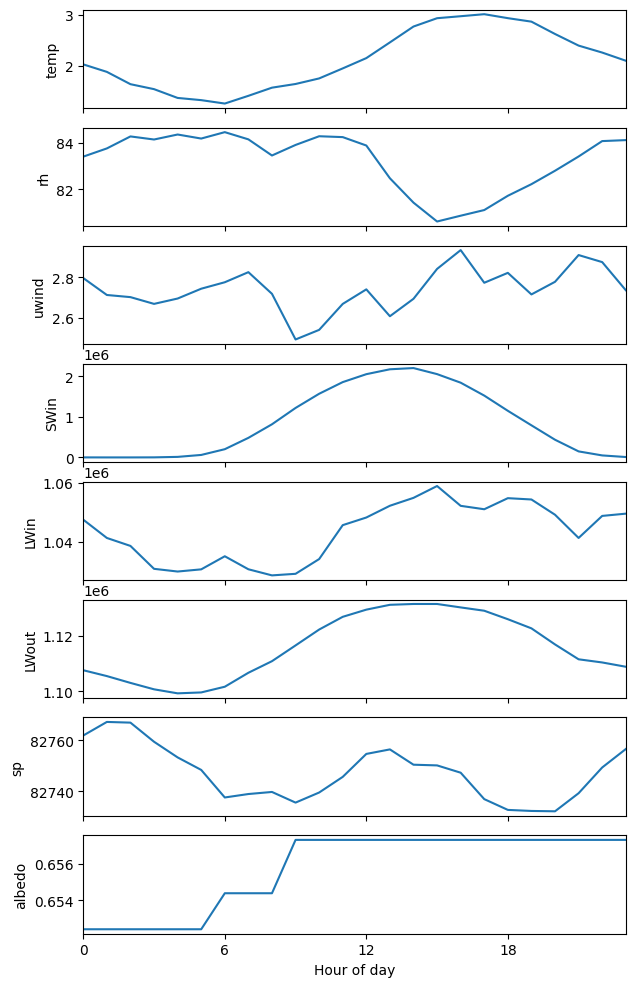

In [24]:
# check how many variables there are 
full_vars = []
for var in df.columns:
    if df[var].count() > 0:
        full_vars.append(var)
logger.info(f'Data contains: '+', '.join(full_vars))

# make subplots
nvars = len(full_vars)
fig,axis = plt.subplots(nvars,1,figsize=(7,1.5*nvars),sharex=True)

# add hour of day column
df['hour'] = pd.to_datetime(df.index).hour

# loop through and plot variables
for i,var in enumerate(full_vars):
    var_hourly = []
    for hour in np.arange(24):
        # select the dataframe by the hour and find the mean
        ds_hour = df[df['hour'] == hour]
        hourly_mean = np.mean(ds_hour[var])
        var_hourly.append(hourly_mean)
    axis[i].plot(np.arange(24),var_hourly)
    axis[i].set_ylabel(var)
    axis[i].set_xlim((0,23))
axis[i].set_xlabel('Hour of day')
axis[i].set_xticks([0,6,12,18])
plt.show()

df = df.drop(columns=['hour'])

In [25]:
# Optional: drop outgoing fluxes if you want the model to calculate albedo / surface temperature
# df = df.drop(columns=['SWout','LWout'])

In [27]:
# Store data
if ('SWout' in df.columns and 'LWout' in df.columns) or ('albedo' in df.columns and 'LWout' in df.columns):
    export_fn_use = export_fn.replace('.csv','allrad.csv')
elif 'albedo' in df.columns:
    export_fn_use = export_fn.replace('.csv','walbedo.csv')
else:
    export_fn_use = export_fn
df.to_csv(export_fn_use)
print(f'Saved data to {export_fn_use}')

# Store metadata
new_line = f'{glac_name}\t{station_name}\t{elev}\t{lat}\t{lon}\t{station_type}\n'

# Read existing lines to check if this station is already written
with open(metadata_fn, 'r') as f:
    lines = f.readlines()
    existing_lines = set(line.strip() for line in lines[1:])

# Write new lines
if new_line.split('\n')[0] not in existing_lines:
    with open(metadata_fn, 'a') as f:
        f.write(new_line)
    print(f'& metadata to {metadata_fn}')
else:
    print('& metadata is already written')

Saved data to ../../../climate_data/AWS/Processed/gulkana/gulkanaB2025allrad.csv
& metadata is already written


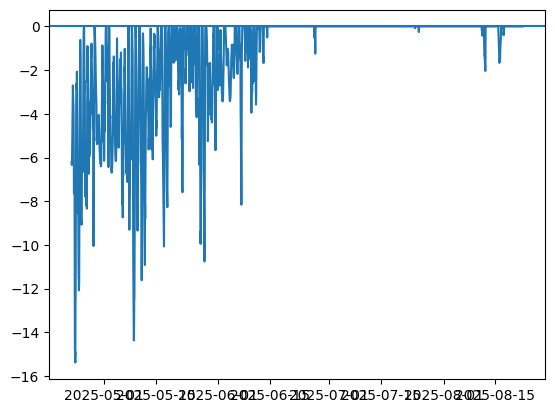

In [27]:
TS = (df['LWout'] / 3600 / 5.67e-8)**(1/4) - 273.15
plt.plot(df.index, TS)
plt.axhline(0)
plt.show()

In [ ]:
# ===== DONE! =====